-----
## Exercise 3: Going Deeper

As usual, pick **AT LEAST ONE** of the following exercises to complete.

### Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

Use my (or even better, improve on my) implementation of `REINFORCE` to solve the [Lunar Lander Environment](https://gymnasium.farama.org/environments/box2d/lunar_lander/). This environment is a little bit harder than Cartpole, but not much. Make sure you perform the same types of analyses we did during the lab session to quantify and qualify the performance of your agents.

### Exercise 3.2: Solving Cartpole and Lunar Lander with `Deep Q-Learning` (harder)

On policy Deep Reinforcement Learning tends to be **very unstable**. Write an implementation (or adapt an existing one) of `Deep Q-Learning` to solve our two environments (Cartpole and Lunar Lander). To do this you will need to implement a **Replay Buffer** and use a second, slow-moving **target Q-Network** to stabilize learning.

### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.

 

In [18]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

import math
from collections import namedtuple, deque
from itertools import count

# Exercise 3.1: Solving Lunar Lander with `REINFORCE` (easy)

In [3]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))


def select_action2(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    return (action.item())

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()


# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        env.render()
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)


def run_episode2(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        env.render()
        obs = torch.tensor(obs)
        action = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions,  rewards)

In [4]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env, inner=16):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner)
        self.fc2 = nn.Linear(inner, env.action_space.n)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s

# A simple, but generic, policy network with one hidden layer.
class BaselineNet(nn.Module):
    def __init__(self, env, inner=16):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner)
        self.fc2 = nn.Linear(inner, 1)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return s
    

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(*args)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, N,  env, env_render=None, gamma=0.99, num_episodes=10, baseline=None, display=False, comment='', mini_batch=50):
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-3)
    target_policy = policy
    # If we have a baseline network, create the optimizer.
    if isinstance(baseline, nn.Module):
        opt_baseline = torch.optim.Adam(baseline.parameters(), lr=1e-3)
        baseline.train()
        print('Training agent with baseline value network.')
    elif baseline == 'std':
        print('Training agent with standardization baseline.')
    else:
        print('Training agent with no baseline.')
        
    # Track episode rewards in a list.
    running_rewards = [0.0]
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        #replay_buffer = []
        # Run an episode of the environment, collect everything needed for policy update.
        v = run_episode(env, target_policy)
        if len(v)<mini_batch:
            (observations, actions, log_probs, rewards) = v
        else:
            (observations, actions, log_probs, rewards) = random.sample(v, mini_batch)
        #replay_buffer.append((observations, actions, log_probs, rewards))
        # Compute the discounted reward for every step of the episode.
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
        #v = random.sample(replay_buffer,mini_batch)
            
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        
        # Handle baseline.
        if isinstance(baseline, nn.Module):
            with torch.no_grad():
                target = returns - baseline(torch.stack(observations))
        elif baseline == 'std':
            target = (returns - returns.mean()) / returns.std()
        else:
            target = returns
        
        # Make an optimization step
        opt.zero_grad()

        # Update policy network
        loss = (-log_probs * target).mean()
        loss.backward()
        opt.step()
        
        # Update baseline network.
        if isinstance(baseline, nn.Module):
            opt_baseline.zero_grad()
            loss_baseline = ((returns - baseline(torch.stack(observations)))**2.0).mean()
            loss_baseline.backward()
            opt_baseline.step()
        
        # Render an episode after every 100 policy updates.
        if not episode % 100:
            breakpoint()
            if display:
                policy.eval()
                (obs, _, _, _) = run_episode(env_render, policy)
                policy.train()
            print(f'Running reward: {running_rewards[-1]}')
        
        if episode % N:
            target_policy= policy
    
    # Return the running rewards.
    policy.eval()
    if isinstance(baseline, nn.Module):
        baseline.eval()
    return running_rewards

In [6]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


def deep_q(policy, N, env, mini_batch=50, env_render=None, gamma=0.99, num_episodes=10, baseline=None, display=False, comment='' ):
    memory = ReplayMemory(1000)
    target_policy = policy
    opt = torch.optim.Adam(policy.parameters(), lr=1e-3)
    running_rewards = [0.0]
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        #replay_buffer = []
        # Run an episode of the environment, collect everything needed for policy update.
        v = run_episode(env, target_policy)
        if len(v)<mini_batch:
            (observations, actions, log_probs, rewards) = v
        else:
            (observations, actions, log_probs, rewards) = random.sample(v, mini_batch)

NameError: name 'namedtuple' is not defined

c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training agent with baseline value network.


c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\gymnasium\envs\classic_control\cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Running reward: 0.6062709331512451
Running reward: 19.528285438505787
Running reward: 18.281430065204972
Running reward: 23.114441148449057
Running reward: 26.018947080721684
Running reward: 30.525440354496688
Running reward: 34.0358021252995
Running reward: 40.12696732834528
Running reward: 48.74539913128046
Running reward: 65.23168265911778
Running reward: 76.86276865859509
Running reward: 81.78377447164769
Running reward: 87.4362799196845
Running reward: 91.8410402786324
Running reward: 91.29235293632021
Running reward: 93.68388085093584
Running reward: 93.5447103717694
Running reward: 93.82018143208828
Running reward: 96.7060883375681
Running reward: 97.02602085932713
Running reward: 97.63135496178529
Running reward: 96.49007017146998
Running reward: 96.94322435372526
Running reward: 97.92727622384311
Running reward: 97.06383321966184
Running reward: 95.92390348060621
Running reward: 97.92924915973701
Running reward: 95.53633423141304
Running reward: 97.72296440553532
Running rewar

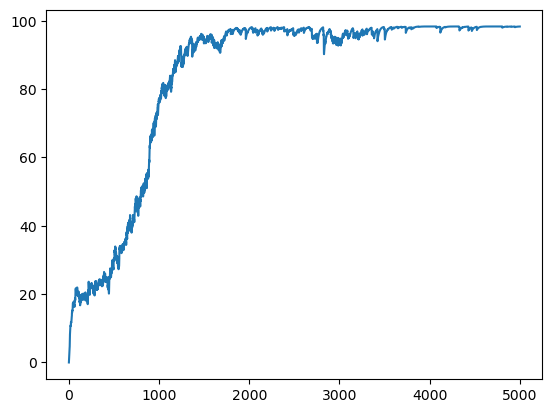

In [7]:
env = gym.make('CartPole-v1')
env_render = gym.make('CartPole-v1', render_mode='human')

# Make a policy network.
policy = PolicyNet(env, inner=16)
baseline = BaselineNet(env, inner=16)

# Train the agent.
plt.plot(reinforce(policy,50, env, env_render, num_episodes=5000, gamma=0.99, baseline=baseline, comment='-NO-BASELINE-INNER=16', mini_batch=100))

# Close up everything
env_render.close()
env.close()

In [12]:
env_render = gym.make('CartPole-v1', render_mode='human')
for _ in range(5):
    run_episode(env_render, policy)
env_render.close()

In [51]:
#env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [52]:
#In output c'è un valore di Q per ogni azione, n_observation è la dimensione dello spazio degli stati
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 32)
        self.layer2 = nn.Linear(32, 32)
        self.layer3 = nn.Linear(32, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [44]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [53]:
# batch_size: is the number of transitions sampled from the replay buffer
# gamma: is the discount factor as mentioned in the previous section
# eps_start: is the starting value of epsilon
# eps_end: is the final value of epsilon
# eps_decay: controls the rate of exponential decay of epsilon, higher means a slower decay
# tau: is the update rate of the target network
# lr: is the learning rate of the ``AdamW`` optimizer

batch_size = 32 #128 for CartPole
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005
lr = 0.0005
update_target = 10
update_freq =4
memory_size = 200000

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

#Queste reti restituiscono il Q value, non i logits delle azioni
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
memory = ReplayMemory(memory_size)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * \
        math.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [46]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [55]:
num_episodes = 500
#running_rewards=[0.0]
average_score=deque(maxlen=100)
for i_episode in range(num_episodes):
    # Initialize the environment and get its state, and initialize score for lunar_lander episode
    score = 0
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    #discounted_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        #discounted_reward += GAMMA**(t+1)*reward
        score += reward
        
        done = terminated or truncated

        if terminated:
            #running_rewards.append(0.05 * discounted_reward + 0.95 * running_rewards[-1])
            average_score.append(score)
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
    
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        if i_episode%update_freq:
            optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        target_net.load_state_dict(target_net_state_dict)

        #Update target network every N episodes
        #if i_episode% update_target :
        #    target_net_state_dict = target_net.state_dict()
        #    policy_net_state_dict = policy_net.state_dict()
        #    for key in policy_net_state_dict:
        #        target_net_state_dict[key] = policy_net_state_dict[key]

        if done:
            #episode_durations.append(t + 1)
            average_score.append(score)
            #running_rewards.append(0.05 * discounted_reward + 0.95 * running_rewards[-1])
            #plot_durations()
            break
    print(np.average(average_score),f'episode:{i_episode}')

#print('Complete')
#plot_durations(show_result=True)
#plt.ioff()
#plt.show()

227.1351306396008 episode:0
-150.2605508771141 episode:1
-308.4428502131635 episode:2
-348.07133502623606 episode:3
-367.14948969391924 episode:4
-373.8029962767593 episode:5
-354.32258316818974 episode:6
-334.659762779487 episode:7
-303.96532375438215 episode:8
-305.3642416261464 episode:9
-305.875544752594 episode:10
-285.2510505772864 episode:11
-270.8432167646652 episode:12
-261.68209580118935 episode:13
-247.50514418028712 episode:14
-219.6328540206344 episode:15
-198.31365959559741 episode:16
-189.18573228434778 episode:17
-187.61946483513614 episode:18
-182.21171632771615 episode:19
-178.5924493169618 episode:20
-175.972787140051 episode:21
-171.03965862222344 episode:22
-165.14850278813338 episode:23
-158.59090211944456 episode:24
-154.01260969415935 episode:25
-153.58437715939988 episode:26
-150.46835458130604 episode:27
-150.93116326210594 episode:28
-147.16022742111429 episode:29
-146.31620426709404 episode:30
-142.23727007086273 episode:31
-140.85500364224762 episode:32
-14

In [49]:
env = gym.make("LunarLander-v2", render_mode="human")
state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
b=0
for _ in range(600):
    
    action = select_action(state)
    observation, reward, terminated, truncated, info = env.step(action.item())
    

    if terminated or truncated:
        b+=1
        state, info = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    
    else:
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        
print(b)
env.close()

1


### Exercise 3.3: Solving the OpenAI CarRacing environment (hardest) 

Use `Deep Q-Learning` -- or even better, an off-the-shelf implementation of **Proximal Policy Optimization (PPO)** -- to train an agent to solve the [OpenAI CarRacing](https://github.com/andywu0913/OpenAI-GYM-CarRacing-DQN) environment. This will be the most *fun*, but also the most *difficult*. Some tips:

1. Make sure you use the `continuous=False` argument to the environment constructor. This ensures that the action space is **discrete** (we haven't seen how to work with continuous action spaces).
2. Your Q-Network will need to be a CNN. A simple one should do, with two convolutional + maxpool layers, folowed by a two dense layers. You will **definitely** want to use a GPU to train your agents.
3. The observation space of the environment is a single **color image** (a single frame of the game). Most implementations stack multiple frames (e.g. 3) after converting them to grayscale images as an observation.


In [ ]:
gym.make("CarRacing-v2", continuous= False)

In [19]:
import cv2
import numpy as np

#Functions to take RGB image to grayscale and to put the 3 frames in place of the RGB channels

def process_state_image(state):
    state = cv2.cvtColor(state, cv2.COLOR_BGR2GRAY)
    state = state.astype(float)
    state /= 255.0
    return state

def generate_state_frame_stack_from_queue(deque):
    frame_stack = np.array(deque)
    # Move stack dimension to the channel dimension (stack, x, y) -> (x, y, stack)
    return np.transpose(frame_stack, (1, 2, 0))

In [ ]:
#HYPERPARAMETERS

gamma = 0.95
memory_size =5000
epsilon_decay= 0.9999
epsilon_min = 0.1
learning_rate= 0.001

memory = deque(maxlen=memory_size)

In [ ]:
class DQNA_car(nn.Module):
    def __init__(self, env, frame_stack_num = 3):

        self.model = nn.Sequential(
                    nn.Conv2d(frame_stack_num,6, kernel_size=7, stride= 3),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Conv2d(6,12, kernel_size= 4),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2),
                    nn.Flatten(),
                    nn.LazyLinear(216),
                    nn.ReLU(),
                    nn.Linear(216, env.action_space.n)
        )
    def forward(self, x):
        return self.model(x)

model= DQNA_car()
target_model=model
model.to(device)
target_model.to(device)

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    



In [ ]:
#Take actions based on epsilon greedy
def act(env, model, state, epsilon):
        if np.random.rand() > epsilon:
            act_values = model(state)   #.predict(np.expand_dims(state, axis=0))
            action_index = np.argmax(act_values[0])
        else:
            action_index = random.randrange(env.action_space.n)
        return env.action_space[action_index]


In [ ]:
def replay(model, batch_size, memory, epochs):
        minibatch = random.sample(memory, batch_size)
        train_state = []
        train_target = []
        for state, action_index, reward, next_state, done in minibatch:
            target = model(np.expand_dims(state, axis=0))[0]
            if done:
                target[action_index] = reward
            else:
                t = target_model(np.expand_dims(next_state, axis=0))[0]
                target[action_index] = reward + gamma * np.max(t)
            train_state.append(state)
            train_target.append(target)
        

        model.train()
        optimizer.zero_grad()
        inputs = np.array(train_state).to(device)
        targets = np.array(train_target).to(device)
        output = model(inputs)
        criterion = nn.MSELoss()
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)


        model.fit(np.array(train_state), np.array(train_target), epochs=1, verbose=0)
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

In [ ]:
RENDER                        = True
STARTING_EPISODE              = 1
ENDING_EPISODE                = 1000
SKIP_FRAMES                   = 2
TRAINING_BATCH_SIZE           = 64
SAVE_TRAINING_FREQUENCY       = 25
UPDATE_TARGET_MODEL_FREQUENCY = 5
frame_stack_num               = 3
epsilon                       = 1
memory                        = deque(maxlen=memory_size)
optimizer                     = optim.AdamW(policy_net.parameters(), lr=lr, eps=1e-7)

#memory = ReplayMemory(memory_size)

for e in range(STARTING_EPISODE, ENDING_EPISODE+1):
        init_state = env.reset()
        init_state = process_state_image(init_state)

        total_reward = 0
        negative_reward_counter = 0
        state_frame_stack_queue = deque([init_state]*frame_stack_num, maxlen=frame_stack_num)
        time_frame_counter = 1
        done = False

        while True:
            if RENDER:
                env.render()

            current_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)
            action = act(current_state_frame_stack, model, epsilon)

            reward = 0
            for _ in range(SKIP_FRAMES+1):
                next_state, r, done, info = env.step(action)
                reward += r
                if done:
                    break
            
            # If continually getting negative reward 10 times after the tolerance steps, terminate this episode
            negative_reward_counter = negative_reward_counter + 1 if time_frame_counter > 100 and reward < 0 else 0

            # Extra bonus for the model if it uses full gas
            if action[1] == 1 and action[2] == 0:
                reward *= 1.5

            total_reward += reward

            next_state = process_state_image(next_state)
            state_frame_stack_queue.append(next_state)
            next_state_frame_stack = generate_state_frame_stack_from_queue(state_frame_stack_queue)

            #agent.memorize(current_state_frame_stack, action, reward, next_state_frame_stack, done)
            memory.append((state, env.action_space.index(action), reward, next_state, done))
            

            if done or negative_reward_counter >= 25 or total_reward < 0:
                print('Episode: {}/{}, Scores(Time Frames): {}, Total Rewards(adjusted): {:.2}, Epsilon: {:.2}'.format(e, ENDING_EPISODE, time_frame_counter, float(total_reward), float(epsilon)))
                break
            if len(memory) > TRAINING_BATCH_SIZE:
                agent.replay(TRAINING_BATCH_SIZE)
                minibatch = random.sample(memory, TRAINING_BATCH_SIZE)
            time_frame_counter += 1



        if e % UPDATE_TARGET_MODEL_FREQUENCY == 0:
            target_model.load_state_dict(model.state_dict())

        if e % SAVE_TRAINING_FREQUENCY == 0:
            model.save('./save/trial_{}.h5'.format(e))

